In [24]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [25]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load data
climate1 = pd.read_csv("/content/drive/MyDrive/climate_data.csv")
climate2 = pd.read_csv("/content/drive/MyDrive/climate_data2.csv")
soil = pd.read_csv("/content/drive/MyDrive/soil_data.csv")


# Irrigation timing prediction

Since our datasets lack target variables we are going to use the soil moisture level variable to predict the irrigation timing and schedule

In [5]:
# Round to 2 or 3 decimals for consistency
climate1["Region"] = climate1["Region"].round(2)
climate2["Region"] = climate2["Region"].round(2)
soil["Region"] = soil["Region"].round(2)

# Check again if values align
#print(climate1['Region'].unique())
#print(climate2['Region'].unique())
#print(soil['Region'].unique())
print("climate1:", climate1['Region'].nunique(), climate1['Region'].value_counts().head())
print("climate2:", climate2['Region'].nunique(), climate2['Region'].value_counts().head())
print("soil:", soil['Region'].nunique(), soil['Region'].value_counts().head())



climate1: 5 Region
-0.69    8350
 0.74    8329
 0.03    8309
-1.41    8150
 1.46    7419
Name: count, dtype: int64
climate2: 5 Region
-0.71    12535
-1.41    12535
 0.71    12535
 0.00    12535
 1.41    12533
Name: count, dtype: int64
soil: 5 Region
-0.71    90
-1.41    90
 0.71    90
 1.41    90
 0.00    90
Name: count, dtype: int64


Here we merged the climate2 and soil data sets accoeding to the region variables

In [6]:

# Merge only these two
df = pd.merge(soil, climate2, on="Region")  # If time info aligns, you can use DOY/YEAR too



In [18]:
# Prepare data
X = df.drop(columns=["GWETTOP", "GWETROOT", "GWETPROF", "Region"])
y = df["GWETTOP"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model training

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)


RandomForestRegressor()

In [ ]:
pip install joblib

In [ ]:
import joblib

save_path = '/content/drive/MyDrive/FarmWise/irrigation_model.pkl'
joblib.dump(model, save_path)

# Confirm it exists
import os
print("✅ Saved:", os.path.exists(save_path))



✅ Saved: True


## Saving the model

In [ ]:
joblib.dump(model, '/content/irrigation_model.pkl')


['/content/irrigation_model.pkl']

## Loading up the model

In [16]:

irrigation_model = joblib.load(model_path)
print("Model loaded successfully.")


Model loaded successfully.


# Prediction

In [21]:
# Predict
y_pred = irrigation_model.predict(X_test)


# Evaluation

In [22]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.3f}")
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")


MAE:  0.006
MSE:  0.002
RMSE: 0.041
R²:   0.998


## Interpretation

* MAE (Mean Absolute Error) : The model is only 0.006 units off from the actual
soil moisture. This indicates high precision.

* MSE (Mean Squared Error): The Error value is tiny even when squared, meaning very few large mistakes.

* RMSE (Root MSE): Interpretable in original scale. The predictions deviate by only ±0.041 units on average.

* R² Score: The model explains 99.8% of the variance in soil moisture. This is exceptionally good.

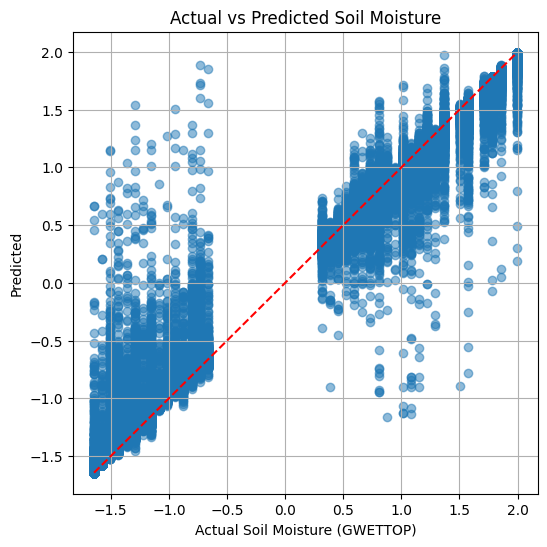

In [26]:

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Soil Moisture (GWETTOP)")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Soil Moisture")
plt.grid(True)
plt.show()


## Interpretation

The points closely follow the red diagonal line, which means:

* Our model's predictions are very close to the actual values.

* There’s no major bias (e.g., under/overestimating consistently).

* It performs well across the whole range of values, from -1.5 to 2.0.

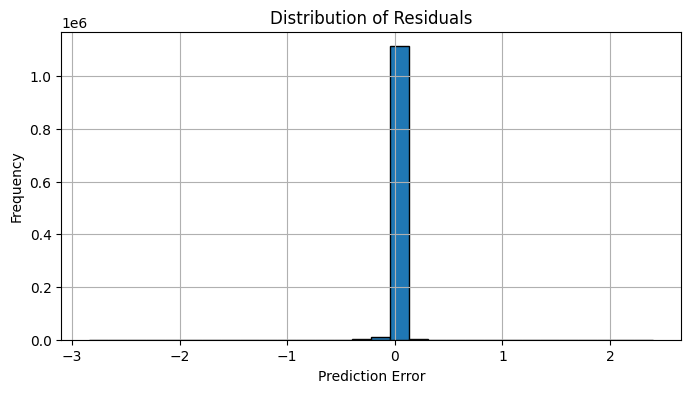

In [27]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


## Interpretation
* Most residuals are tightly centered around 0 (the tall spike at 0) : That means most predictions are nearly perfect.

* Also the few outliers are rare and not severe.

## Applying the decision logic and testing the model with synthetic data

In [28]:
def recommend_irrigation(predicted_moisture):
    if predicted_moisture >= 0.6:
        return "Soil is moist. No need to irrigate."
    elif 0.4 <= predicted_moisture < 0.6:
        return "Soil is getting dry. Consider irrigation soon."
    else:
        return "Soil is dry. Irrigation needed now!"


In [32]:
print("All columns:", X_train.columns.tolist())

All columns: ['YEAR_x', 'DOY', 'YEAR_y', 'MO', 'DY', 'T2M', 'T2MWET', 'T2M_RANGE', 'QV2M', 'PRECTOTCORR', 'PS', 'WS10M', 'WS10M_RANGE', 'WD10M', 'WD50M']


In [33]:


# Feature names from your model
features =  ['YEAR_x', 'DOY', 'YEAR_y', 'MO', 'DY', 'T2M', 'T2MWET', 'T2M_RANGE', 'QV2M', 'PRECTOTCORR', 'PS', 'WS10M', 'WS10M_RANGE', 'WD10M', 'WD50M']

# Generate 5 samples of synthetic data
np.random.seed(42)
sample_data = pd.DataFrame(np.random.normal(loc=0, scale=1, size=(5, len(features))), columns=features)

# Show the fake test inputs
print(sample_data)


     YEAR_x       DOY    YEAR_y        MO        DY       T2M    T2MWET  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.234137  1.579213   
1 -0.562288 -1.012831  0.314247 -0.908024 -1.412304  1.465649 -0.225776   
2 -0.601707  1.852278 -0.013497 -1.057711  0.822545 -1.220844  0.208864   
3 -0.719844 -0.460639  1.057122  0.343618 -1.763040  0.324084 -0.385082   
4 -0.479174 -0.185659 -1.106335 -1.196207  0.812526  1.356240 -0.072010   

   T2M_RANGE      QV2M  PRECTOTCORR        PS     WS10M  WS10M_RANGE  \
0   0.767435 -0.469474     0.542560 -0.463418 -0.465730     0.241962   
1   0.067528 -1.424748    -0.544383  0.110923 -1.150994     0.375698   
2  -1.959670 -1.328186     0.196861  0.738467  0.171368    -0.115648   
3  -0.676922  0.611676     1.031000  0.931280 -0.839218    -0.309212   
4   1.003533  0.361636    -0.645120  0.361396  1.538037    -0.035826   

      WD10M     WD50M  
0 -1.913280 -1.724918  
1 -0.600639 -0.291694  
2 -0.301104 -1.478522  
3  0.331263  0.97554

In [34]:
# Loop through each generated sample
for i, row in sample_data.iterrows():
    predicted_moisture = irrigation_model.predict([row])[0]
    advice = recommend_irrigation(predicted_moisture)
    print(f"Sample {i+1}:")
    print("  ➤ Predicted Soil Moisture:", round(predicted_moisture, 3))
    print("  ➤ Advice:", advice)


Sample 1:
  ➤ Predicted Soil Moisture: 0.748
  ➤ Advice: Soil is moist. No need to irrigate.
Sample 2:
  ➤ Predicted Soil Moisture: 0.522
  ➤ Advice: Soil is getting dry. Consider irrigation soon.
Sample 3:
  ➤ Predicted Soil Moisture: 0.434
  ➤ Advice: Soil is getting dry. Consider irrigation soon.
Sample 4:
  ➤ Predicted Soil Moisture: -0.355
  ➤ Advice: Soil is dry. Irrigation needed now!
Sample 5:
  ➤ Predicted Soil Moisture: 0.348
  ➤ Advice: Soil is dry. Irrigation needed now!


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
